In [1]:
import os
import librosa
import torch
import torchaudio
import numpy as np
from sklearn.model_selection import train_test_split

# Path to dataset
DATA_PATH = "/kaggle/input/google-speech-commands/"

# Hyperparameters
SAMPLE_RATE = 16000
DURATION = 1.0  
N_MELS = 128
N_FFT = 400

def load_audio(file_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
    audio = librosa.util.fix_length(audio, size=int(target_sr * duration))  # Pad/Trim
    return audio

def extract_features(file_path):
    """Extract mel spectrogram features"""
    audio = load_audio(file_path)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [3]:
import os
from collections import defaultdict

def count_files_per_class(data_path):
    class_counts = defaultdict(int)
    for label in os.listdir(data_path):
        folder = os.path.join(data_path, label)
        if os.path.isdir(folder) and label != "_background_noise_":
            for file_name in os.listdir(folder):
                if file_name.endswith(('.wav', '.mp3', '.flac')):
                    class_counts[label] += 1
    return class_counts

# Show file counts
file_counts = count_files_per_class(DATA_PATH)
for cls, count in file_counts.items():
    print(f"{cls}: {count} files")


no: 2375 files
two: 2373 files
four: 2372 files
five: 2357 files
nine: 2364 files
right: 2367 files
off: 2357 files
yes: 2377 files
six: 2369 files
dog: 1746 files
left: 2353 files
bird: 1731 files
wow: 1745 files
zero: 2376 files
eight: 2352 files
bed: 1713 files
go: 2372 files
house: 1750 files
tree: 1733 files
seven: 2377 files
on: 2367 files
three: 2356 files
one: 2370 files
down: 2359 files
stop: 2380 files
up: 2375 files
happy: 1742 files
marvin: 1746 files
cat: 1733 files
sheila: 1734 files


In [5]:
def create_balanced_dataset(data_path):
    X, y = [], []
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    label_map = {label: idx for idx, label in enumerate(classes)}

    # Count files per class
    class_to_files = {cls: [] for cls in classes}
    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if file_path.endswith(('.wav', '.mp3', '.flac')):
                class_to_files[label].append(file_path)

    # Determine minimum class count
    min_class_count = min(len(files) for files in class_to_files.values())

    # Collect features with balanced sampling
    for label in classes:
        selected_files = class_to_files[label][:min_class_count]  # balance
        for file_path in selected_files:
            features = extract_features(file_path)
            X.append(features)
            y.append(label_map[label])
    
    return np.array(X), np.array(y), label_map

X, y, label_map = create_balanced_dataset(DATA_PATH)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch Datasets
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


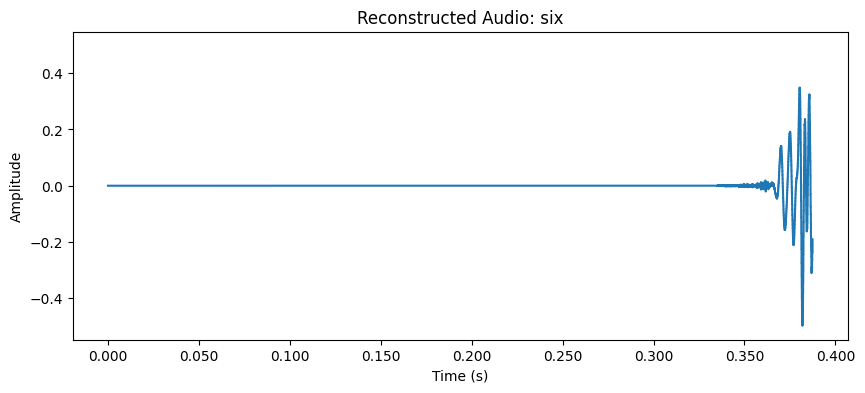

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio

label_map = {0: 'bed', 1: 'bird', 2: 'cat', 3: 'dog', 4: 'down', 5: 'eight',
             6: 'five', 7: 'four', 8: 'go', 9: 'happy', 10: 'house', 11: 'left',
             12: 'marvin', 13: 'nine', 14: 'no', 15: 'off', 16: 'on', 17: 'one',
             18: 'right', 19: 'seven', 20: 'sheila', 21: 'six', 22: 'stop',
             23: 'three', 24: 'tree', 25: 'two', 26: 'up', 27: 'wow', 28: 'yes', 29: 'zero'}
HOP_LENGTH = N_FFT // 2 
# Loop through the batches
for batch in train_loader:
    audio, labels = batch
    
    # Extract the first sample
    mel_spectrogram = audio[0].numpy()  # Convert tensor to numpy
    label_idx = labels[0].item()  # Get the label index
    class_name = label_map[label_idx]  # Map to class name

    
    mel_power = librosa.db_to_power(mel_spectrogram)

    
    mel_to_linear = librosa.feature.inverse.mel_to_stft(
        mel_power, sr=SAMPLE_RATE, n_fft=N_FFT, power=1.0
    )

   
    waveform = librosa.griffinlim(mel_to_linear, hop_length=HOP_LENGTH, win_length=N_FFT)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
    plt.title(f"Reconstructed Audio: {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Play the reconstructed audio
    display(Audio(waveform, rate=SAMPLE_RATE))

    break 

In [12]:
for batch in train_loader:
    audios, labels = batch
    print(audios[0].shape)
    print(audios[0])
    print(labels[0].shape)
    print(labels[0])
    break

torch.Size([128, 32])
tensor([[-50.3932, -44.1281, -48.2595,  ..., -35.2636, -26.2743, -30.1633],
        [-46.4906, -40.2255, -44.3569,  ..., -31.3611, -22.3717, -26.2607],
        [-47.6686, -42.3343, -41.1312,  ..., -29.2551, -22.3087, -28.5273],
        ...,
        [-80.0000, -80.0000, -80.0000,  ..., -69.1399, -67.9599, -69.6320],
        [-80.0000, -80.0000, -80.0000,  ..., -74.1203, -79.2118, -73.7087],
        [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -75.2013]])
torch.Size([])
tensor(10)


In [32]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        return x + self.pe[:, :x.size(1), :]

class LSTMTransformerClassifier(nn.Module):
    def __init__(self, input_dim=128, lstm_hidden=128, num_classes=10, num_heads=2, ff_dim=256):
        super().__init__()

        # LSTM
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden,
                            num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)

        self.embedding_dim = lstm_hidden * 2  # bidirectional LSTM

        # Positional Encoding + Transformer
        self.pos_encoder = PositionalEncoding(self.embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True, dropout=0.2)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(self.embedding_dim, num_classes)
        )

    def forward(self, x):
        # x: (batch, mel_bins, time_steps) → (batch, time_steps, mel_bins)
        x = x.permute(0, 2, 1)

        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden*2)

        # Transformer
        x = self.pos_encoder(lstm_out)
        x = self.transformer(x)  # (batch, seq_len, embed_dim)

        # Global pooling + classification
        x = x.permute(0, 2, 1)  # for AdaptiveAvgPool1d
        out = self.classifier(x)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTransformerClassifier(input_dim=128, num_classes=len(label_map)).to(device)
model.apply(init_weights)
print(model)

LSTMTransformerClassifier(
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (pos_encoder): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=25

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 10
train(model, train_loader, criterion, optimizer, device, num_epochs)


In [47]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        

        print(f'Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.2f}%')

    return epoch_losses, epoch_accuracies


Epoch 1/20: 100%|██████████| 643/643 [00:06<00:00, 94.07it/s, accuracy=44.1, loss=1.07] 


Epoch 1: Loss = 1.8700, Accuracy = 44.06%


Epoch 2/20: 100%|██████████| 643/643 [00:06<00:00, 94.86it/s, accuracy=73.1, loss=1.2]  


Epoch 2: Loss = 0.8700, Accuracy = 73.05%


Epoch 3/20: 100%|██████████| 643/643 [00:06<00:00, 94.20it/s, accuracy=78, loss=0.548]  


Epoch 3: Loss = 0.7132, Accuracy = 77.97%


Epoch 4/20: 100%|██████████| 643/643 [00:06<00:00, 94.63it/s, accuracy=80.5, loss=0.864]


Epoch 4: Loss = 0.6267, Accuracy = 80.49%


Epoch 5/20: 100%|██████████| 643/643 [00:06<00:00, 94.68it/s, accuracy=82.1, loss=0.8]  


Epoch 5: Loss = 0.5825, Accuracy = 82.05%


Epoch 6/20: 100%|██████████| 643/643 [00:06<00:00, 94.68it/s, accuracy=83, loss=0.644]  


Epoch 6: Loss = 0.5467, Accuracy = 82.97%


Epoch 7/20: 100%|██████████| 643/643 [00:06<00:00, 94.60it/s, accuracy=83.3, loss=0.318]


Epoch 7: Loss = 0.5352, Accuracy = 83.30%


Epoch 8/20: 100%|██████████| 643/643 [00:06<00:00, 94.14it/s, accuracy=84.5, loss=0.334]


Epoch 8: Loss = 0.5042, Accuracy = 84.52%


Epoch 9/20: 100%|██████████| 643/643 [00:06<00:00, 94.62it/s, accuracy=84.8, loss=0.609]


Epoch 9: Loss = 0.4891, Accuracy = 84.78%


Epoch 10/20: 100%|██████████| 643/643 [00:06<00:00, 94.48it/s, accuracy=84.8, loss=0.474]


Epoch 10: Loss = 0.4921, Accuracy = 84.79%


Epoch 11/20: 100%|██████████| 643/643 [00:06<00:00, 94.85it/s, accuracy=85.4, loss=0.542]


Epoch 11: Loss = 0.4783, Accuracy = 85.43%


Epoch 12/20: 100%|██████████| 643/643 [00:06<00:00, 93.93it/s, accuracy=85.5, loss=0.565]


Epoch 12: Loss = 0.4708, Accuracy = 85.53%


Epoch 13/20: 100%|██████████| 643/643 [00:06<00:00, 94.65it/s, accuracy=86.2, loss=0.306]


Epoch 13: Loss = 0.4378, Accuracy = 86.22%


Epoch 14/20: 100%|██████████| 643/643 [00:06<00:00, 94.77it/s, accuracy=86, loss=0.365]  


Epoch 14: Loss = 0.4549, Accuracy = 86.02%


Epoch 15/20: 100%|██████████| 643/643 [00:06<00:00, 94.51it/s, accuracy=86, loss=0.308]  


Epoch 15: Loss = 0.4531, Accuracy = 85.99%


Epoch 16/20: 100%|██████████| 643/643 [00:06<00:00, 94.16it/s, accuracy=86.4, loss=0.203]


Epoch 16: Loss = 0.4393, Accuracy = 86.36%


Epoch 17/20: 100%|██████████| 643/643 [00:06<00:00, 94.60it/s, accuracy=87.1, loss=0.188]


Epoch 17: Loss = 0.4110, Accuracy = 87.08%


Epoch 18/20: 100%|██████████| 643/643 [00:06<00:00, 94.86it/s, accuracy=87.2, loss=0.21] 


Epoch 18: Loss = 0.4139, Accuracy = 87.20%


Epoch 19/20: 100%|██████████| 643/643 [00:06<00:00, 94.56it/s, accuracy=87.1, loss=0.657]


Epoch 19: Loss = 0.4087, Accuracy = 87.13%


Epoch 20/20: 100%|██████████| 643/643 [00:06<00:00, 95.03it/s, accuracy=87.6, loss=0.241]


Epoch 20: Loss = 0.4022, Accuracy = 87.55%


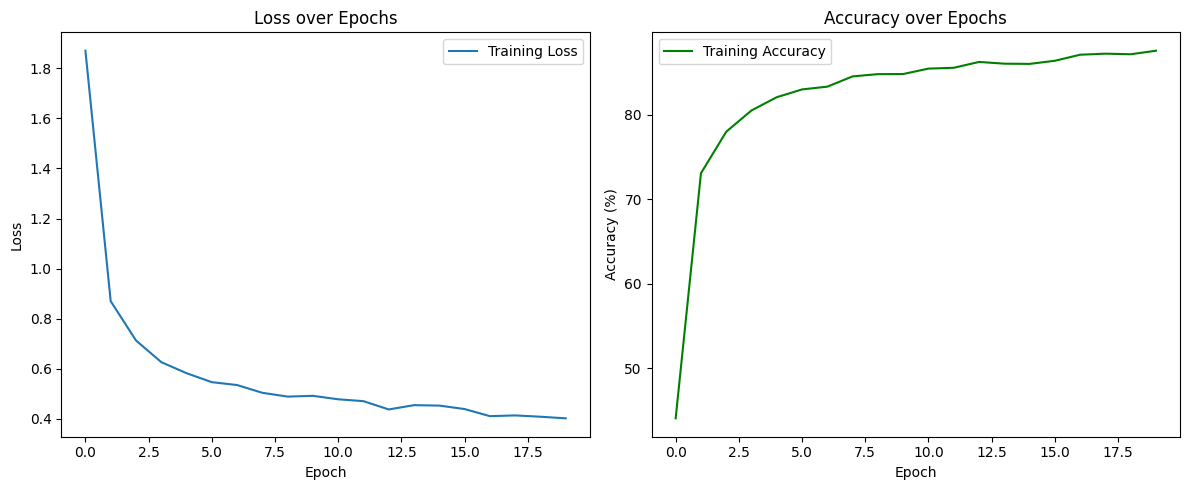

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 20

losses, accuracies = train(model, train_loader, criterion, optimizer, device, num_epochs)

# Plot
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Training Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


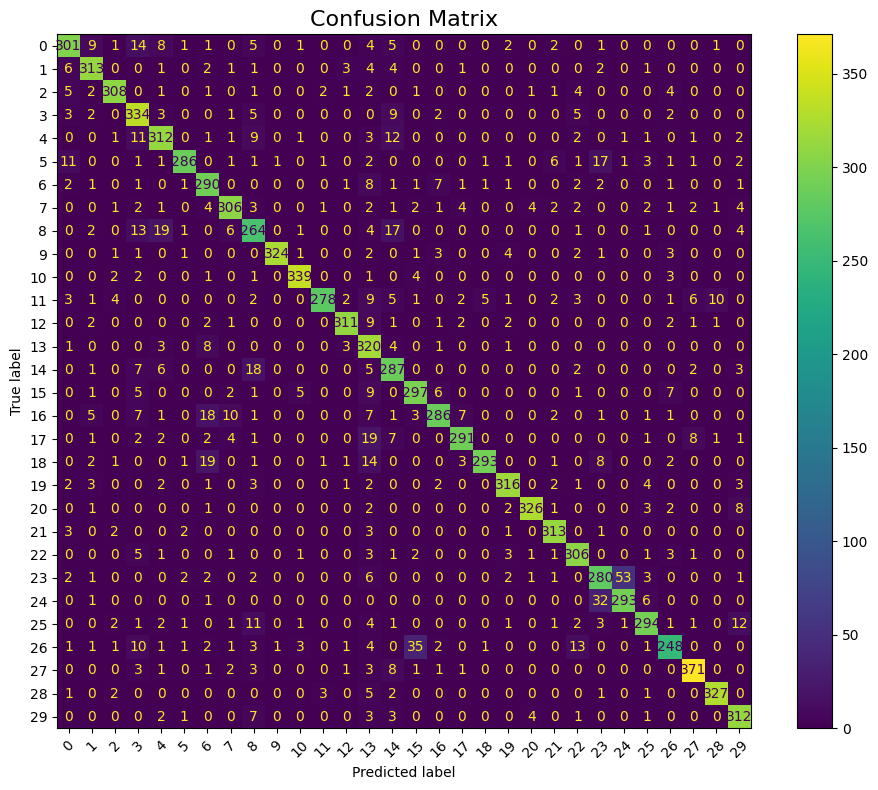

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_and_confusion_matrix(model, test_loader, device, label_map):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    display_labels = list(label_map.keys())

    fig, ax = plt.subplots(figsize=(10, 8))  # ← Increased size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(xticks_rotation=45, cmap='viridis', values_format='d', ax=ax)
    
    plt.title("Confusion Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()

evaluate_and_confusion_matrix(model, test_loader, device, label_map)

In [56]:
def evaluate(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(data_loader, desc="Evaluating", leave=True)

    for batch in loop:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Transpose inputs for transformer
        #inputs = inputs.transpose(1, 2)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

evaluate(model, test_loader, criterion, device)

Evaluating: 100%|██████████| 161/161 [00:00<00:00, 212.38it/s, accuracy=86.8, loss=0.477]

Validation Loss: 0.4567, Accuracy: 86.84%
